## Fitting a linear regression model with pytorch

In this notebook you will see how to use Pytorch to fit the parameters (slope and intercept) of a simple linear regression model via gradient descent (GD).

**Dataset:** You work with the systolic blood pressure and age data of 33 American women, which is generated and visualized in the upper part of the notebook.

**Content:**

* fit a linear model via the sklearn machine learning library of python to get the fitted values of the intercept and slope as reference.
* use the Pytorch library to fit the parameter of the simple linear model via GD with the objective to minimize the MSE loss.
    * define the model
    * define the loss and the optimizer
    * fit the model parameters via GD and check the current values of the estimated model parameters and the loss after each updatestep
    * verify that the estimated parameters converge to the values which you got from the sklearn fit.  


#### Imports

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import torch
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D


Here we read in the systolic blood pressure and the age of the 33 American women in our dataset. Then we use the sklearn library to find the optimal values for the slope a and the intercept b.

In [13]:
# Blood Pressure data
x = [22, 41, 52, 23, 41, 54, 24, 46, 56, 27, 47, 57, 28, 48, 58,  9,
     49, 59, 30, 49, 63, 32, 50, 67, 33, 51, 71, 35, 51, 77, 40, 51, 81]
y = [131, 139, 128, 128, 171, 105, 116, 137, 145, 106, 111, 141, 114,
     115, 153, 123, 133, 157, 117, 128, 155, 122, 183,
     176,  99, 130, 172, 121, 133, 178, 147, 144, 217]
x = np.asarray(x, np.float32)
y = np.asarray(y, np.float32)

## Ordinary Least Squares (OLS)



As you probably know there is a closed form solution for linear regression

The coefficients $ \hat{\beta} $ in OLS regression are calculated by minimizing the residual sum of squares:

$$
\hat{\beta} = \underset{\beta}{\text{argmin}} \, ||y - X\beta||^2
$$

The solution is given by the closed-form formula:

$$
\hat{\beta} = (X^T X)^{-1} X^T y
$$

Where:
- $ X $: Data matrix,
- $ y $: Target vector,
- $ X^T $: Transpose of $ X $,
- $ (X^T X)^{-1} $: Inverse of $ X^T X $.

This can be calculated with numpy:

In [18]:
# Closed-form OLS calculation
X = np.c_[np.ones(x.shape[0]), x]  # Add all 1 for intercept
beta = np.linalg.inv(X.T @ X) @ X.T @ y
mse_ols = mean_squared_error(y, beta[1] * x + beta[0])
res1 = pd.DataFrame(
          {'a':beta[1],'b':beta[0],'mse':mse_ols}, index=['OLS "by Hand"'])
res1

,a,b,mse
"OLS ""by Hand""",1.105022,87.671422,349.200836


## Scikit learn
Lets check the result of

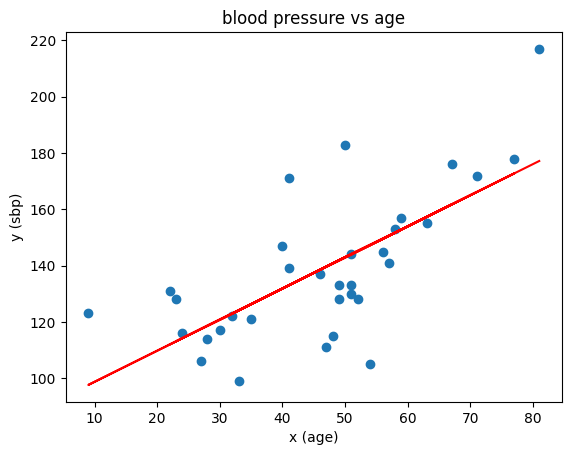

intercept (b) =  87.67143 , slope (a) =  1.1050216 , Mean Squared Error (MSE ) =  349.20078


,a,b,mse
"OLS ""by Hand""",1.105022,87.671422,349.200836
Sklearn Linear Regression,1.105022,87.671422,349.200836


In [19]:
plt.scatter(x=x,y=y)
plt.title("blood pressure vs age")
plt.xlabel("x (age)")
plt.ylabel("y (sbp)")

model = LinearRegression()
res = model.fit(x.reshape((len(x),1)), y)
predictions = model.predict(x.reshape((len(x),1)))
plt.plot(x, predictions,color="red")
plt.show()
mse = mean_squared_error(y, predictions)

res2 = pd.DataFrame(
          {'a':beta[1],'b':beta[0],'mse':mse_ols}, index=['Sklearn Linear Regression'])
pd.concat([res1,res2])

## Visualization of the Loss Surface


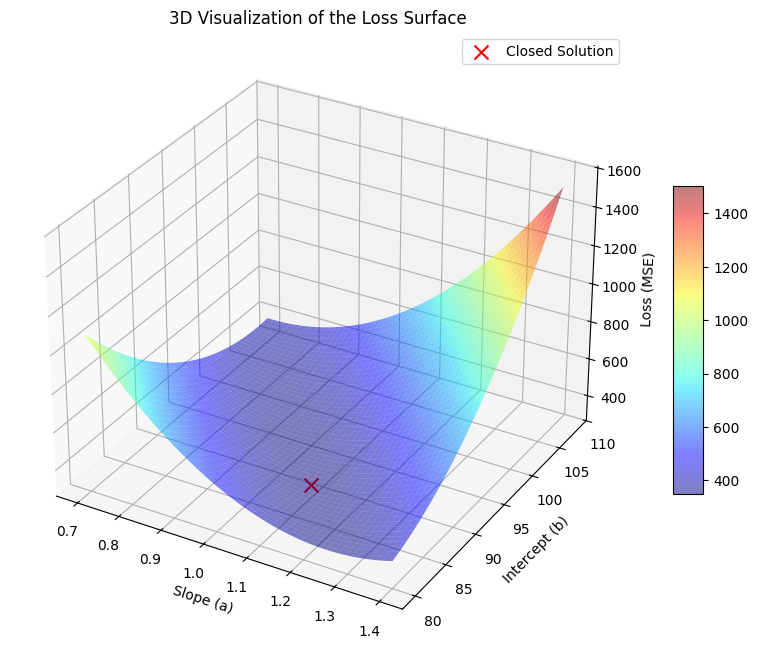

In [5]:
# Define ranges for slope (a) and intercept (b)
a_range = np.linspace(0.7, 1.4, 100)  # Slope values
b_range = np.linspace(80, 108, 100)  # Intercept values
A, B = np.meshgrid(a_range, b_range)
loss_surface = np.zeros_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        a_val = A[i, j]
        b_val = B[i, j]
        y_pred = a_val * x + b_val
        loss_surface[i, j] = np.mean((y - y_pred) ** 2)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# plot
surface = ax.plot_surface(A, B, loss_surface, cmap='jet', alpha=0.5)
ax.set_xlabel('Slope (a)')
ax.set_ylabel('Intercept (b)')
ax.set_zlabel('Loss (MSE)')
ax.set_title('3D Visualization of the Loss Surface')
fig.colorbar(surface, ax=ax, shrink=0.5, aspect=10)
ax.scatter(res.coef_[0],res.intercept_ , mse,  marker='x',color='red', s=100, label='Closed Solution')
ax.legend()
plt.show()

## Pytorch

We now use Torch to define the computational graph then we will run the graph and automatically get the gradients of the loss w.r.t the variables (slope a  and intercept b) to update them.

Lets run it and see how the values of a and b converge to the optimal solution

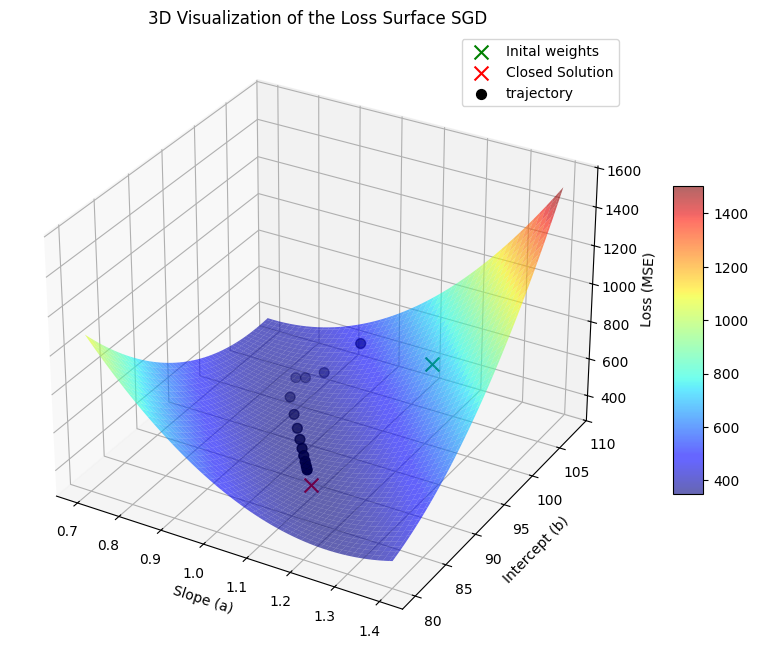

Epoch: 90000, slope: 1.070069432258606, intercept: 89.48454284667969, mse: 349.5655822753906


In [22]:
#torch like torch tensors, we have to convert them, also the data should not get be able to be derivable requires_grad=False
x_torch = torch.tensor(x, requires_grad=False)
y_torch = torch.tensor(y, requires_grad=False)

# Initial weights a and b , we set them somweher close to the optimal solution -> try to change them and see what happens..
# Further these two weights (also tensors now need to be updatable and to be subject for derivation requires_grad=True)
initial_b= 101.0
initial_a= 1.2
a = torch.tensor([initial_a], requires_grad=True)  # slope
b = torch.tensor([initial_b], requires_grad=True)  # intercept

# Define optimizer
optimizer = torch.optim.SGD([a, b], lr=0.0001)

#how many epochs to train
epochs= 100_000
update_interval = 10_000  # Plot only every n epochs

# Lists to store values of a and b for visualization
a_vals, b_vals, display_loss ,display_epochs = [], [], [],[]

#trainign run
for epoch in range(epochs):
    optimizer.zero_grad()
    y_hat = a * x_torch + b # linear model..
    loss = torch.mean((y_torch - y_hat) ** 2) # mse loss

    # Backpropagation
    loss.backward()
    optimizer.step()

    #Plotting
    if epoch in [1, 2, 3] or epoch % update_interval == 0:
        clear_output(wait=True)
        # Save values for visualization
        a_vals.append(a.item())
        b_vals.append(b.item())
        display_loss.append(loss.item())
        display_epochs.append(epoch)

        # plot

        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        surface = ax.plot_surface(A, B, loss_surface, cmap='jet', alpha=0.6)
        ax.set_xlabel('Slope (a)')
        ax.set_ylabel('Intercept (b)')
        ax.set_zlabel('Loss (MSE)')
        ax.set_title('3D Visualization of the Loss Surface SGD')
        fig.colorbar(surface, ax=ax, shrink=0.5, aspect=10)
        ax.scatter(initial_a,initial_b, mean_squared_error(y, initial_a * x + initial_b),  marker='x',color='green', s=100, label='Inital weights')
        ax.scatter(res.coef_[0],res.intercept_ , mse,  marker='x',color='red', s=100, label='Closed Solution')
        ax.scatter(a_vals,b_vals , display_loss,color='black', s=50, label='trajectory')
        ax.legend()
        plt.show()
        print(f"Epoch: {epoch}, slope: {a.item()}, intercept: {b.item()}, mse: {loss.item()}")

In [23]:
res3 = pd.DataFrame(
          {'a':a.detach().numpy(),'b': b.detach().numpy(),'mse':loss.detach().numpy()}, index=['torch SGD'])
pd.concat([res1,res2,res3])

,a,b,mse
"OLS ""by Hand""",1.105022,87.671422,349.200836
Sklearn Linear Regression,1.105022,87.671422,349.200836
torch SGD,1.076974,89.126358,349.435730


## 🔧 **YOUR TASK:**

When you compare the results of the 3 approaches what do you observe?   
- Try to explain the differences
- What could you do to improve?  

In [8]:
### Your code here ###

### `🔑` **Solution:**

<details>
<summary style="font-size:50px;"> 🔑  Click for answers </summary>
  
  -  The SDG does not find the optimal solutions that quick, however it  is very close, if you change the learning rate or train longer, you  will get the optimal solution as well.

  -  The Adam Optimizer reaches the optimum after some steps by dynamically adapting the gradients. -> check code below
</details>


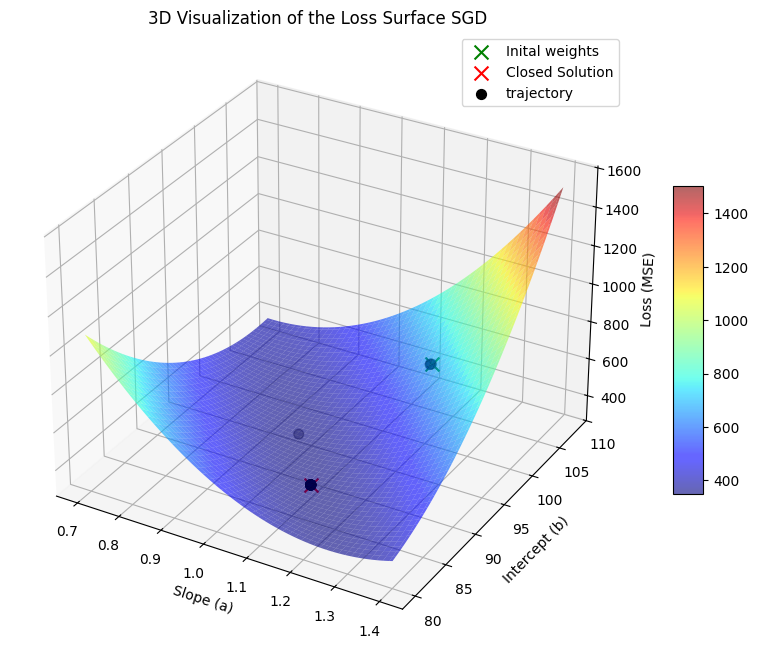

Epoch: 90000, slope: 1.105021357536316, intercept: 87.67142486572266, mse: 349.2008972167969


,a,b,mse
"OLS ""by Hand""",1.105022,87.671422,349.200836
Sklearn Linear Regression,1.105022,87.671422,349.200836
torch SGD,1.076974,89.126358,349.435730
torch ADAM,1.105023,87.671417,349.200867


In [25]:
# @title Solution Code { display-mode: "form" }
# Initial weights a and b , we set them somweher close to the optimal solution -> try to change them and see what happens..
# Further these two weights (also tensors now need to be updatable and to be subject for derivation requires_grad=True)
initial_b= 101.0
initial_a= 1.2
a = torch.tensor([initial_a], requires_grad=True)  # slope
b = torch.tensor([initial_b], requires_grad=True)  # intercept

# Define optimizer
optimizer = torch.optim.Adam([a, b])#<----------------------------------- Different Optimiezer here

#how many epochs to train
epochs= 100_000
update_interval = 10_000  # Plot only every n epochs

#trainign run
a_vals, b_vals, display_loss ,display_epochs = [], [], [],[]
for epoch in range(epochs):
    optimizer.zero_grad()
    y_hat = a * x_torch + b # linear model..
    loss = torch.mean((y_torch - y_hat) ** 2) # mse loss

    # Backpropagation
    loss.backward()
    optimizer.step()

    #Plotting
    if epoch in [1, 2, 3] or epoch % update_interval == 0:

        clear_output(wait=True)
        # Save values for visualization
        a_vals.append(a.item())
        b_vals.append(b.item())
        display_loss.append(loss.item())

        display_epochs.append(epoch)

        # plot
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        surface = ax.plot_surface(A, B, loss_surface, cmap='jet', alpha=0.6)
        ax.set_xlabel('Slope (a)')
        ax.set_ylabel('Intercept (b)')
        ax.set_zlabel('Loss (MSE)')
        ax.set_title('3D Visualization of the Loss Surface SGD')
        fig.colorbar(surface, ax=ax, shrink=0.5, aspect=10)
        ax.scatter(initial_a,initial_b, mean_squared_error(y, initial_a * x + initial_b),  marker='x',color='green', s=100, label='Inital weights')
        ax.scatter(res.coef_[0],res.intercept_ , mse,  marker='x',color='red', s=100, label='Closed Solution')
        ax.scatter(a_vals,b_vals , display_loss,color='black', s=50, label='trajectory')
        ax.legend()
        plt.show()
        print(f"Epoch: {epoch}, slope: {a.item()}, intercept: {b.item()}, mse: {loss.item()}")


res4 = pd.DataFrame(
          {'a':a.detach().numpy(),'b': b.detach().numpy(),'mse':loss.detach().numpy()}, index=['torch ADAM'])
pd.concat([res1,res2,res3,res4])
